### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import os
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import torchvision
from torchvision import models
from apex import amp

from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2, ToTensor

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import cv2
import skimage.io
import IPython.display as display
from PIL import Image

plt.ion()
%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Local Imports

In [3]:
# Paths
from chestxray.config import (PANDA_PATH,
                              MODEL_PATH,
                              PANDA_IMGS,
                              PANDA_MASKS,
                              TRAIN_CSV)
# Competition related config
from chestxray.config import CFG

# Misc
from chestxray.misc import seed_torch

# Datasets
from chestxray.datasets import get_transforms, TrainDataset, ZeroDataset

# Viz
from chestxray.visualize import (show_from_ids, show_batch, imshow, 
                                 plot_classes_preds, reverse_show_img, 
                                 plot_confusion_matrix)

# Nets
from chestxray.nets import TinyV2ConvNet, make_RN50_cls
from chestxray.model_utils import (trainable_params, cce_loss_at_init, 
                                   init_last_layer_bias)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
print(torch.cuda.get_device_properties(device))

_CudaDeviceProperties(name='GeForce RTX 2070 SUPER', major=7, minor=5, total_memory=7979MB, multi_processor_count=40)


### Config

In [6]:
# This notebook is debug only (to check all moving parts make sense)
CFG.debug = False
EXP_NAME = "rn50_512"

### Fix Random Seed

In [7]:
seed_torch()

#### Define Writer for Run


In [8]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/{EXP_NAME}')

### Load Data

In [9]:
TRAIN_DF = pd.read_csv(TRAIN_CSV)
TRAIN_DF.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


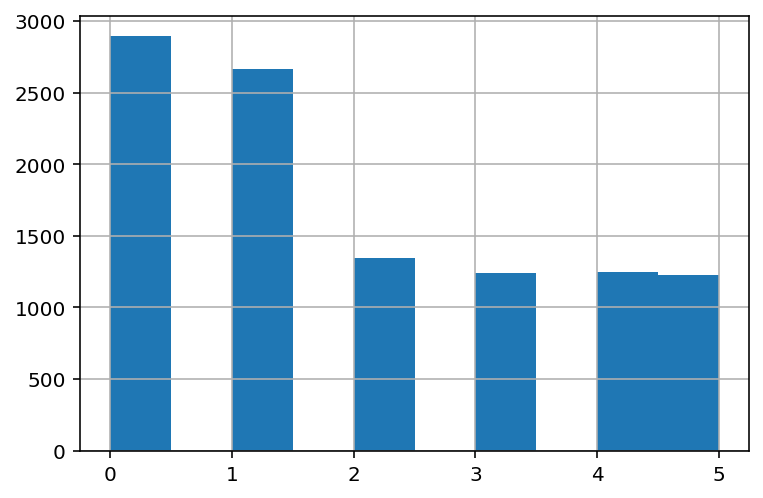

In [10]:
_ = TRAIN_DF[CFG.target_col].hist()

### Train Eval Loop

In [11]:
def train_eval_loop(train_dataset, val_dataset, model, optimizer, criterion, batch_sz=CFG.batch_size, num_epochs=CFG.epoch, tb_tag="", model_name="debug"):
    # Write first layer weights to TB
    if not CFG.debug:
        conv1_weight = model.conv1.weight.data.to("cpu")
        img_grid = torchvision.utils.make_grid(conv1_weight, normalize=True)
        writer.add_image(tag=f"Model conv1 weights {tb_tag}", img_tensor=img_grid, global_step=0)
    
    # define a data loader
    train_dataloader = DataLoader(train_dataset, batch_size=batch_sz, shuffle=True, num_workers=6)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_sz, shuffle=False, num_workers=4)
    model.to(device)
    if CFG.use_amp:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
    
#     scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True, eps=1e-6)
#     scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    # Define epochs numbers to look into input images and predictions
    # No more than 10 times per full training
    vis_step = np.ceil(num_epochs/10).astype(int)
    visual_epochs = list(range(0, num_epochs, vis_step))
    
#     best_qwk = -100
    best_val_loss = np.inf
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Training Phase
        # Set training mode
        model.train();
        train_running_loss = 0.0
        train_epoch_preds, train_epoch_labels = [], []
        # create random step
        rand_step = np.random.randint(0, len(train_dataloader))
        
        # Iterate over train data.
        tk_train = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for i, data in tk_train:
            # Calculate global step
            train_global_step = epoch * len(train_dataloader) + i
            
            inputs, labels = data
            # Visualize input to the model:
            if epoch in visual_epochs and i == rand_step:
                img = reverse_show_img(inputs[0])
                writer.add_image(tag=f"Input Image {tb_tag}", img_tensor=img, global_step=train_global_step, dataformats="HWC")
                del img
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            if CFG.use_amp:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            optimizer.step()
            # loss is mean across batch, multiply by batch size
            # divide by number of steps in epoch (so loss is normalized)
            train_running_loss += loss.item() / len(train_dataloader)
            # tensorboarding loss
            writer.add_scalar(tag=f"Training loss {tb_tag}", scalar_value=loss.item(), global_step=train_global_step)
            
            # collect train preds and labels for QWK
            train_epoch_preds.append(outputs.data.to('cpu').numpy().argmax(1))
            train_epoch_labels.append(labels.to('cpu').numpy())
        
        # Validation Phase
        # Set evaluation mode
        model.eval();
        val_running_loss = 0.0
        val_epoch_preds, val_epoch_labels = [], []
        # Iterate over val data
        tk_val = tqdm(enumerate(val_dataloader), total=len(val_dataloader))
        for j, data in tk_val:
            # Calculate global step
            val_global_step = epoch * len(val_dataloader) + j
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() / len(val_dataloader)
            # tensorboarding loss
            writer.add_scalar(tag=f"Validation loss {tb_tag}", scalar_value=loss.item(), global_step=val_global_step)
            
            # collect validation preds and labels for QWK
            val_epoch_preds.append(outputs.data.to('cpu').numpy().argmax(1))
            val_epoch_labels.append(labels.to('cpu').numpy())
            
            # visualise predictions for 0th validation batch
            if epoch in visual_epochs and j == 0:
                writer.add_figure(tag=f"Actuals vs Predictions {tb_tag}", figure=plot_classes_preds(outputs.to('cpu'), inputs.to('cpu'), labels.to('cpu')), 
                                  global_step=val_global_step)
        
#         scheduler.step()
        # "End of Epoch" Phase
        print(f'Training Loss: {train_running_loss:.4f}\tValidation Loss: {val_running_loss:.4f}')
        
        # Calculate epoch QWK and preds distribution
        train_epoch_preds = np.concatenate(train_epoch_preds)
        train_epoch_labels = np.concatenate(train_epoch_labels)
        val_epoch_preds = np.concatenate(val_epoch_preds)
        val_epoch_labels = np.concatenate(val_epoch_labels)
        print(f'Counter train preds: {Counter(train_epoch_preds)}\tCounter val preds: {Counter(val_epoch_preds)}')
        
        train_qwk = cohen_kappa_score(train_epoch_preds, train_epoch_labels, weights='quadratic')
        val_qwk = cohen_kappa_score(val_epoch_preds, val_epoch_labels, weights='quadratic')
        print(f"Epoch train QWK: {train_qwk:.3f}\tval QWK: {val_qwk:.3f}")
        writer.add_scalar(tag=f"Training QWK {tb_tag}", scalar_value=train_qwk, global_step=epoch)
        writer.add_scalar(tag=f"Validation QWK {tb_tag}", scalar_value=val_qwk, global_step=epoch)
        
        # On the best val loss do:
        if val_running_loss < best_val_loss:
            # update best and save model
            best_val_loss = val_running_loss
            print(f'  Epoch {epoch} - Save Best Loss: {best_val_loss:.4f} Model')
            torch.save(model.state_dict(), f'{MODEL_PATH}/{model_name}.pth')
            
            # add losses as text to TB
            writer.add_text("On save:", 
                            f"tr_loss: {train_running_loss:.4f}, tr_qwk: {train_qwk:.4f}, val_loss: {val_running_loss:.4f}, val_qwk: {val_qwk:.4f}",
                            global_step=train_global_step)
            
            # add image of conv1 weights to TB
            if not CFG.debug:
                conv1_weight = model.conv1.weight.data.to("cpu")
                img_grid = torchvision.utils.make_grid(conv1_weight, normalize=True)
                writer.add_image(tag=f"Model conv1 weights {tb_tag}", img_tensor=img_grid, global_step=train_global_step)
            
            # add confusion matrix to TB
            writer.add_figure(tag=f"Confusion matrix {tb_tag}", figure=plot_confusion_matrix(val_epoch_labels, val_epoch_preds), 
                                  global_step=val_global_step)
    
    writer.close()

### Prepare CV - strategy

In [12]:
if CFG.debug:
    folds_fn = "folds_db.csv"
    try: 
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.sample(n=100, random_state=CFG.seed).reset_index(drop=True).copy()
else:
    folds_fn = "folds.csv"
    try:
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.copy()

In [13]:
if not (PANDA_PATH/folds_fn).exists():
    train_labels = folds[CFG.target_col].values
    kf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for fold, (train_index, val_index) in enumerate(kf.split(folds.values, train_labels)):
        folds.loc[val_index, 'fold'] = int(fold)
    folds['fold'] = folds['fold'].astype(int)
    folds.to_csv(PANDA_PATH/folds_fn, index=None)
    folds.head()

In [14]:
folds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10616 entries, 0 to 10615
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       10616 non-null  object
 1   data_provider  10616 non-null  object
 2   isup_grade     10616 non-null  int64 
 3   gleason_score  10616 non-null  object
 4   fold           10616 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 414.8+ KB


### Debug Runs

In [ ]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/debug')

In [16]:
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()
train_ds = TrainDataset(train_df, transform=get_transforms(data="train"), debug=False)
val_ds = TrainDataset(val_df, transform=get_transforms(data="valid"), debug=False)

model_ft = make_RN50_cls()
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr, amsgrad=False)
train_eval_loop(train_ds, val_ds, model_ft, optimizer, criterion, num_epochs=6)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Epoch 0/5
----------


  1%|          | 3/498 [00:01<04:08,  1.99it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


  1%|          | 6/498 [00:02<02:55,  2.81it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


  4%|▎         | 18/498 [00:06<02:41,  2.96it/s]


KeyboardInterrupt: 

### Experiment Run

In [15]:
print(CFG.__dict__)

{'__module__': 'chestxray.config', 'debug': False, 'use_amp': True, 'img_height': 512, 'img_width': 512, 'lr': 0.0001, 'batch_size': 16, 'epoch': 30, 'seed': 1982, 'target_size': 6, 'img_id_col': 'image_id', 'target_col': 'isup_grade', 'n_fold': 4, '__dict__': <attribute '__dict__' of 'CFG' objects>, '__weakref__': <attribute '__weakref__' of 'CFG' objects>, '__doc__': None}


In [16]:
writer.add_text("Experiment Description:", f"{CFG.__dict__}")

In [17]:
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()
train_ds = TrainDataset(train_df, transform=get_transforms(data="train"), debug=False)
val_ds = TrainDataset(val_df, transform=get_transforms(data="valid"), debug=False)

model_ft = make_RN50_cls()
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr, amsgrad=False)
train_eval_loop(train_ds, val_ds, model_ft, optimizer, criterion, model_name=EXP_NAME)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Epoch 0/29
----------


  1%|          | 3/498 [00:01<04:45,  1.73it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


  1%|          | 6/498 [00:02<03:08,  2.61it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 166/166 [00:16<00:00,  9.97it/s]


Training Loss: 1.4665	Validation Loss: 1.4490
Counter train preds: Counter({0: 3032, 1: 2581, 5: 993, 3: 546, 4: 509, 2: 301})	Counter val preds: Counter({0: 1226, 1: 761, 3: 299, 2: 266, 5: 66, 4: 36})
Epoch train QWK: 0.500	val QWK: 0.468
  Epoch 0 - Save Best Loss: 1.4490 Model
Confusion matrix, without normalization
[[659  53   2   5   2   2]
 [311 304  27  19   3   2]
 [ 72 166  60  34   1   2]
 [ 56 105  48  87   6   9]
 [ 82  88  60  61  11  11]
 [ 46  45  69  93  13  40]]
Epoch 1/29
----------


100%|██████████| 166/166 [00:14<00:00, 11.21it/s]


Training Loss: 1.3407	Validation Loss: 1.3155
Counter train preds: Counter({0: 2896, 1: 2475, 5: 1001, 4: 639, 3: 516, 2: 435})	Counter val preds: Counter({0: 862, 1: 632, 5: 470, 4: 306, 2: 269, 3: 115})
Epoch train QWK: 0.592	val QWK: 0.633
  Epoch 1 - Save Best Loss: 1.3155 Model
Confusion matrix, without normalization
[[557 111   1   5  34  15]
 [177 306  91  18  55  19]
 [ 34 102  90  24  34  51]
 [ 38  44  55  28  41 105]
 [ 32  48  18  24  97  94]
 [ 24  21  14  16  45 186]]
Epoch 2/29
----------


100%|██████████| 166/166 [00:15<00:00, 10.74it/s]

Training Loss: 1.2716	Validation Loss: 1.3196
Counter train preds: Counter({0: 2722, 1: 2534, 5: 998, 4: 689, 2: 518, 3: 501})	Counter val preds: Counter({0: 883, 1: 742, 5: 611, 2: 209, 4: 106, 3: 103})
Epoch train QWK: 0.629	val QWK: 0.626
Epoch 3/29
----------



100%|██████████| 166/166 [00:16<00:00, 10.14it/s]

Training Loss: 1.1939	Validation Loss: 1.3221
Counter train preds: Counter({0: 2673, 1: 2474, 5: 954, 4: 730, 3: 591, 2: 540})	Counter val preds: Counter({0: 1126, 1: 604, 5: 441, 4: 267, 2: 111, 3: 105})
Epoch train QWK: 0.660	val QWK: 0.615
Epoch 4/29
----------



 37%|███▋      | 183/498 [00:52<01:33,  3.38it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 166/166 [00:14<00:00, 11.67it/s]

Training Loss: 1.0790	Validation Loss: 1.6279
Counter train preds: Counter({0: 2531, 1: 2415, 5: 989, 4: 784, 2: 660, 3: 583})	Counter val preds: Counter({0: 1435, 1: 537, 4: 373, 5: 155, 3: 98, 2: 56})
Epoch train QWK: 0.723	val QWK: 0.543
Epoch 5/29
----------



100%|██████████| 166/166 [00:14<00:00, 11.47it/s]

Training Loss: 0.9349	Validation Loss: 1.6240
Counter train preds: Counter({0: 2469, 1: 2291, 5: 1004, 4: 831, 2: 700, 3: 667})	Counter val preds: Counter({1: 1202, 0: 760, 4: 458, 3: 127, 5: 57, 2: 50})
Epoch train QWK: 0.782	val QWK: 0.575
Epoch 6/29
----------



100%|██████████| 166/166 [00:15<00:00, 10.83it/s]


Training Loss: 0.7516	Validation Loss: 1.9702
Counter train preds: Counter({0: 2333, 1: 2245, 5: 981, 4: 925, 2: 775, 3: 703})	Counter val preds: Counter({1: 1508, 0: 540, 2: 289, 4: 164, 3: 89, 5: 64})
Epoch train QWK: 0.840	val QWK: 0.483
Epoch 7/29
----------


100%|██████████| 166/166 [00:14<00:00, 11.60it/s]

Training Loss: 0.5690	Validation Loss: 1.8170
Counter train preds: Counter({0: 2264, 1: 2141, 4: 959, 5: 953, 2: 893, 3: 752})	Counter val preds: Counter({0: 1172, 5: 527, 1: 370, 4: 255, 2: 246, 3: 84})
Epoch train QWK: 0.889	val QWK: 0.604
Epoch 8/29
----------



100%|██████████| 166/166 [00:14<00:00, 11.56it/s]

Training Loss: 0.3986	Validation Loss: 2.5961
Counter train preds: Counter({0: 2227, 1: 2087, 4: 943, 5: 941, 2: 932, 3: 832})	Counter val preds: Counter({1: 1270, 0: 573, 2: 313, 3: 243, 4: 202, 5: 53})
Epoch train QWK: 0.921	val QWK: 0.532
Epoch 9/29
----------



 67%|██████▋   | 333/498 [01:32<00:43,  3.76it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 166/166 [00:15<00:00, 10.85it/s]


Training Loss: 0.2734	Validation Loss: 1.9737
Counter train preds: Counter({0: 2201, 1: 2054, 2: 946, 5: 938, 4: 926, 3: 897})	Counter val preds: Counter({1: 886, 0: 844, 5: 440, 3: 282, 2: 137, 4: 65})
Epoch train QWK: 0.938	val QWK: 0.628
Epoch 10/29
----------


100%|██████████| 166/166 [00:14<00:00, 11.56it/s]

Training Loss: 0.1860	Validation Loss: 2.2774
Counter train preds: Counter({0: 2183, 1: 2028, 2: 973, 4: 936, 5: 926, 3: 916})	Counter val preds: Counter({1: 853, 0: 730, 2: 307, 4: 304, 5: 278, 3: 182})
Epoch train QWK: 0.966	val QWK: 0.614
Epoch 11/29
----------



100%|██████████| 498/498 [02:17<00:00,  3.61it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



100%|██████████| 166/166 [00:14<00:00, 11.62it/s]

Training Loss: 0.1438	Validation Loss: 2.4345
Counter train preds: Counter({0: 2180, 1: 2027, 2: 991, 5: 923, 4: 923, 3: 918})	Counter val preds: Counter({0: 931, 1: 597, 5: 443, 3: 336, 4: 202, 2: 145})
Epoch train QWK: 0.975	val QWK: 0.644
Epoch 12/29
----------



100%|██████████| 166/166 [00:15<00:00, 10.73it/s]


Training Loss: 0.1475	Validation Loss: 2.9400
Counter train preds: Counter({0: 2200, 1: 1993, 2: 1005, 4: 931, 5: 920, 3: 913})	Counter val preds: Counter({0: 821, 1: 730, 4: 507, 5: 340, 2: 129, 3: 127})
Epoch train QWK: 0.965	val QWK: 0.598
Epoch 13/29
----------


100%|██████████| 166/166 [00:14<00:00, 11.63it/s]

Training Loss: 0.1385	Validation Loss: 2.8731
Counter train preds: Counter({0: 2179, 1: 2014, 2: 996, 4: 934, 3: 925, 5: 914})	Counter val preds: Counter({5: 783, 1: 766, 0: 639, 3: 256, 2: 113, 4: 97})
Epoch train QWK: 0.975	val QWK: 0.592
Epoch 14/29
----------



100%|██████████| 166/166 [00:14<00:00, 11.60it/s]

Training Loss: 0.1242	Validation Loss: 2.8354
Counter train preds: Counter({0: 2185, 1: 2014, 2: 991, 4: 925, 3: 924, 5: 923})	Counter val preds: Counter({5: 630, 0: 585, 1: 521, 4: 473, 3: 271, 2: 174})
Epoch train QWK: 0.973	val QWK: 0.522
Epoch 15/29
----------



100%|██████████| 166/166 [00:15<00:00, 10.88it/s]


Training Loss: 0.0779	Validation Loss: 2.7924
Counter train preds: Counter({0: 2183, 1: 1992, 2: 1006, 4: 936, 3: 926, 5: 919})	Counter val preds: Counter({0: 880, 1: 831, 3: 480, 5: 215, 2: 151, 4: 97})
Epoch train QWK: 0.986	val QWK: 0.603
Epoch 16/29
----------


100%|██████████| 166/166 [00:14<00:00, 11.59it/s]

Training Loss: 0.0993	Validation Loss: 2.7047
Counter train preds: Counter({0: 2174, 1: 2017, 2: 1000, 3: 932, 5: 920, 4: 919})	Counter val preds: Counter({1: 741, 0: 620, 5: 416, 3: 407, 2: 289, 4: 181})
Epoch train QWK: 0.974	val QWK: 0.585
Epoch 17/29
----------



 33%|███▎      | 165/498 [00:46<01:28,  3.74it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 166/166 [00:14<00:00, 11.64it/s]

Training Loss: 0.1216	Validation Loss: 3.4735
Counter train preds: Counter({0: 2193, 1: 1996, 2: 1003, 5: 926, 4: 926, 3: 918})	Counter val preds: Counter({1: 738, 5: 622, 4: 595, 0: 554, 2: 137, 3: 8})
Epoch train QWK: 0.967	val QWK: 0.543
Epoch 18/29
----------



100%|██████████| 166/166 [00:15<00:00, 10.69it/s]


Training Loss: 0.1044	Validation Loss: 3.2364
Counter train preds: Counter({0: 2173, 1: 2008, 2: 999, 3: 938, 4: 923, 5: 921})	Counter val preds: Counter({0: 1290, 4: 375, 1: 347, 5: 277, 2: 254, 3: 111})
Epoch train QWK: 0.977	val QWK: 0.604
Epoch 19/29
----------


100%|██████████| 166/166 [00:14<00:00, 11.63it/s]

Training Loss: 0.0667	Validation Loss: 2.6297
Counter train preds: Counter({0: 2179, 1: 2000, 2: 1002, 4: 935, 3: 929, 5: 917})	Counter val preds: Counter({0: 633, 1: 618, 2: 534, 4: 316, 3: 314, 5: 239})
Epoch train QWK: 0.986	val QWK: 0.617
Epoch 20/29
----------



100%|██████████| 166/166 [00:14<00:00, 11.61it/s]

Training Loss: 0.0882	Validation Loss: 3.8330
Counter train preds: Counter({0: 2182, 1: 2006, 2: 1005, 4: 929, 3: 925, 5: 915})	Counter val preds: Counter({0: 848, 5: 760, 4: 656, 1: 234, 2: 127, 3: 29})
Epoch train QWK: 0.977	val QWK: 0.477
Epoch 21/29
----------



100%|██████████| 166/166 [00:15<00:00, 10.82it/s]


Training Loss: 0.0918	Validation Loss: 2.9216
Counter train preds: Counter({0: 2183, 1: 1997, 2: 1006, 3: 930, 4: 930, 5: 916})	Counter val preds: Counter({0: 723, 1: 698, 4: 525, 5: 298, 3: 245, 2: 165})
Epoch train QWK: 0.977	val QWK: 0.587
Epoch 22/29
----------


100%|██████████| 166/166 [00:14<00:00, 11.61it/s]

Training Loss: 0.0688	Validation Loss: 3.0613
Counter train preds: Counter({0: 2176, 1: 1999, 2: 1004, 4: 941, 3: 927, 5: 915})	Counter val preds: Counter({0: 1036, 5: 493, 2: 487, 1: 406, 4: 184, 3: 48})
Epoch train QWK: 0.987	val QWK: 0.581
Epoch 23/29
----------



100%|██████████| 166/166 [00:14<00:00, 11.61it/s]

Training Loss: 0.0538	Validation Loss: 2.8430
Counter train preds: Counter({0: 2174, 1: 2002, 2: 1003, 4: 932, 3: 928, 5: 923})	Counter val preds: Counter({0: 923, 1: 616, 2: 400, 5: 305, 4: 214, 3: 196})
Epoch train QWK: 0.983	val QWK: 0.590
Epoch 24/29
----------



100%|██████████| 166/166 [00:15<00:00, 10.84it/s]

Training Loss: 0.0962	Validation Loss: 3.2823
Counter train preds: Counter({0: 2180, 1: 1998, 2: 1008, 4: 930, 3: 927, 5: 919})	Counter val preds: Counter({0: 1259, 1: 531, 5: 468, 3: 199, 4: 113, 2: 84})
Epoch train QWK: 0.973	val QWK: 0.584
Epoch 25/29
----------



 48%|████▊     | 241/498 [01:07<01:08,  3.76it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 166/166 [00:14<00:00, 11.60it/s]

Training Loss: 0.0890	Validation Loss: 3.2064
Counter train preds: Counter({0: 2182, 1: 1997, 2: 1004, 3: 932, 4: 930, 5: 917})	Counter val preds: Counter({0: 1181, 1: 547, 2: 450, 5: 305, 4: 98, 3: 73})
Epoch train QWK: 0.981	val QWK: 0.550
Epoch 26/29
----------



  9%|▉         | 46/498 [00:13<02:00,  3.76it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 166/166 [00:14<00:00, 11.58it/s]

Training Loss: 0.0596	Validation Loss: 2.8168
Counter train preds: Counter({0: 2183, 1: 1993, 2: 1007, 4: 933, 3: 932, 5: 914})	Counter val preds: Counter({0: 803, 1: 687, 5: 419, 2: 408, 3: 219, 4: 118})
Epoch train QWK: 0.985	val QWK: 0.611
Epoch 27/29
----------



100%|██████████| 166/166 [00:15<00:00, 10.72it/s]


Training Loss: 0.0690	Validation Loss: 3.4654
Counter train preds: Counter({0: 2180, 1: 2001, 2: 1004, 4: 934, 3: 924, 5: 919})	Counter val preds: Counter({1: 963, 0: 521, 2: 339, 3: 315, 5: 308, 4: 208})
Epoch train QWK: 0.984	val QWK: 0.591
Epoch 28/29
----------


100%|██████████| 166/166 [00:14<00:00, 11.59it/s]

Training Loss: 0.0550	Validation Loss: 3.5768
Counter train preds: Counter({0: 2176, 1: 2006, 2: 1003, 4: 937, 3: 929, 5: 911})	Counter val preds: Counter({1: 1102, 0: 785, 3: 258, 4: 248, 5: 235, 2: 26})
Epoch train QWK: 0.985	val QWK: 0.593
Epoch 29/29
----------



100%|██████████| 166/166 [00:14<00:00, 11.61it/s]

Training Loss: 0.0738	Validation Loss: 3.0092
Counter train preds: Counter({0: 2173, 1: 2007, 2: 1000, 3: 935, 4: 924, 5: 923})	Counter val preds: Counter({1: 787, 0: 628, 3: 422, 2: 310, 4: 262, 5: 245})
Epoch train QWK: 0.982	val QWK: 0.593


### Train with CV

In [34]:
checkpoint = "test_fold_{}.pth"
for fold in range(CFG.n_fold):
    train_df = folds[folds["fold"] != fold].copy()
    val_df = folds[folds["fold"] == fold].copy()
    
    train_ds = TrainDataset(train_df, transform=get_transforms(data="train"), debug=False)
    val_ds = TrainDataset(val_df, transform=get_transforms(data="valid"), debug=False)
    
    model = TinyV2ConvNet(CFG.target_size)
    # initialize bias in the model
    cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
    model = init_last_layer_bias(model, cls_probas)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, amsgrad=False)
    print(f"Train with CV, on fold {fold}")
    model = train_eval_loop(train_ds, val_ds, model, optimizer, criterion, tb_tag=fold)
    torch.save(model.state_dict(), MODEL_PATH/checkpoint.format(fold))

Train with CV, on fold 0
Epoch 0/9
----------


100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

Training Loss: 1.7832	Validation Loss: 1.6735
Counter train preds: Counter({1: 50, 4: 11, 3: 8, 0: 6})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.193	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.82it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

Training Loss: 1.5393	Validation Loss: 1.6932
Counter train preds: Counter({1: 39, 0: 21, 3: 7, 4: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.236	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

Training Loss: 1.4436	Validation Loss: 1.7056
Counter train preds: Counter({1: 34, 0: 26, 3: 7, 5: 5, 4: 3})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.321	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.05it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

Training Loss: 1.4152	Validation Loss: 1.6723
Counter train preds: Counter({0: 33, 1: 31, 3: 5, 4: 5, 5: 1})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.282	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.74it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3904	Validation Loss: 1.6386
Counter train preds: Counter({1: 33, 0: 28, 4: 6, 3: 5, 5: 3})	Counter val preds: Counter({1: 15, 5: 3, 0: 3, 2: 2, 4: 1, 3: 1})
Epoch train QWK: 0.393	val QWK: 0.186
Epoch 5/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.53it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

Training Loss: 1.3730	Validation Loss: 1.6927
Counter train preds: Counter({0: 33, 1: 26, 5: 7, 3: 4, 4: 4, 2: 1})	Counter val preds: Counter({1: 13, 5: 6, 2: 4, 3: 1, 0: 1})
Epoch train QWK: 0.517	val QWK: 0.545
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.96it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3238	Validation Loss: 1.8837
Counter train preds: Counter({0: 30, 1: 29, 5: 6, 3: 6, 4: 4})	Counter val preds: Counter({1: 9, 5: 7, 2: 6, 3: 3})
Epoch train QWK: 0.438	val QWK: 0.329
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.85it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

Training Loss: 1.3055	Validation Loss: 2.0990
Counter train preds: Counter({1: 34, 0: 22, 5: 8, 3: 7, 4: 2, 2: 2})	Counter val preds: Counter({2: 12, 5: 5, 3: 5, 1: 2, 4: 1})
Epoch train QWK: 0.552	val QWK: 0.326
Epoch 8/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.66it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

Training Loss: 1.3063	Validation Loss: 2.0883
Counter train preds: Counter({1: 35, 0: 25, 4: 7, 3: 5, 5: 3})	Counter val preds: Counter({2: 13, 5: 5, 1: 3, 3: 2, 4: 1, 0: 1})
Epoch train QWK: 0.549	val QWK: 0.199
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.77it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

Training Loss: 1.3191	Validation Loss: 1.8377
Counter train preds: Counter({1: 37, 0: 24, 5: 7, 4: 3, 3: 3, 2: 1})	Counter val preds: Counter({1: 21, 3: 2, 2: 1, 5: 1})
Epoch train QWK: 0.435	val QWK: 0.305
Train with CV, on fold 1
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.80it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.7209	Validation Loss: 1.7380
Counter train preds: Counter({0: 59, 3: 15, 1: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.263	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.81it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.5459	Validation Loss: 1.7958
Counter train preds: Counter({0: 36, 1: 32, 3: 5, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.331	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.4606	Validation Loss: 1.9763
Counter train preds: Counter({1: 34, 0: 29, 4: 8, 3: 4})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

Training Loss: 1.4206	Validation Loss: 1.8872
Counter train preds: Counter({1: 32, 0: 24, 4: 8, 3: 6, 5: 3, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.441	val QWK: 0.000
Epoch 4/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.28it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4067	Validation Loss: 2.2129
Counter train preds: Counter({1: 36, 0: 25, 3: 10, 5: 2, 2: 1, 4: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.12it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

Training Loss: 1.3640	Validation Loss: 2.9000
Counter train preds: Counter({1: 33, 0: 24, 3: 12, 2: 4, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.364	val QWK: 0.000
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.87it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

Training Loss: 1.3085	Validation Loss: 2.7819
Counter train preds: Counter({1: 33, 0: 20, 3: 11, 2: 4, 4: 4, 5: 3})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.568	val QWK: 0.000
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.36it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

Training Loss: 1.3142	Validation Loss: 2.3783
Counter train preds: Counter({1: 36, 0: 21, 3: 9, 2: 5, 5: 3, 4: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.435	val QWK: 0.116
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.2917	Validation Loss: 3.1009
Counter train preds: Counter({1: 38, 0: 19, 2: 6, 4: 5, 3: 4, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.433	val QWK: 0.009
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.24it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.2545	Validation Loss: 2.9466
Counter train preds: Counter({1: 32, 0: 20, 3: 10, 4: 5, 2: 5, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.635	val QWK: 0.009
Train with CV, on fold 2
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

Training Loss: 1.6856	Validation Loss: 1.8174
Counter train preds: Counter({1: 48, 3: 15, 0: 12})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.208	val QWK: 0.000
Epoch 1/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.45it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.5455	Validation Loss: 2.4182
Counter train preds: Counter({1: 37, 0: 21, 3: 16, 2: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.313	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.4741	Validation Loss: 2.2700
Counter train preds: Counter({1: 33, 0: 26, 3: 14, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.287	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.64it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4289	Validation Loss: 2.4097
Counter train preds: Counter({1: 35, 0: 28, 3: 7, 2: 5})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.247	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.55it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

Training Loss: 1.3615	Validation Loss: 2.0392
Counter train preds: Counter({1: 39, 0: 25, 3: 7, 2: 4})	Counter val preds: Counter({0: 24, 2: 1})
Epoch train QWK: 0.307	val QWK: 0.064
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.67it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

Training Loss: 1.4250	Validation Loss: 1.6867
Counter train preds: Counter({1: 41, 0: 26, 3: 8})	Counter val preds: Counter({0: 20, 2: 3, 1: 2})
Epoch train QWK: 0.266	val QWK: 0.214
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.91it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.3328	Validation Loss: 1.7360
Counter train preds: Counter({1: 34, 0: 24, 3: 12, 2: 4, 5: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.365	val QWK: 0.130
Epoch 7/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.21it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.3236	Validation Loss: 1.8248
Counter train preds: Counter({1: 33, 0: 21, 2: 13, 3: 6, 5: 2})	Counter val preds: Counter({0: 17, 1: 5, 2: 3})
Epoch train QWK: 0.316	val QWK: 0.272
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.99it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

Training Loss: 1.2498	Validation Loss: 2.4719
Counter train preds: Counter({1: 34, 0: 24, 2: 8, 3: 8, 5: 1})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.392	val QWK: 0.259
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.2657	Validation Loss: 2.4212
Counter train preds: Counter({1: 39, 0: 21, 2: 6, 3: 6, 5: 3})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.409	val QWK: 0.259
Train with CV, on fold 3
Epoch 0/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.76it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.7337	Validation Loss: 1.6500
Counter train preds: Counter({1: 49, 2: 14, 0: 6, 5: 3, 3: 3})	Counter val preds: Counter({1: 24, 0: 1})
Epoch train QWK: 0.123	val QWK: -0.030
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.52it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

Training Loss: 1.5647	Validation Loss: 1.7000
Counter train preds: Counter({1: 40, 0: 18, 3: 12, 2: 5})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.232	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.84it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

Training Loss: 1.4733	Validation Loss: 1.6935
Counter train preds: Counter({1: 33, 0: 27, 3: 13, 2: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.337	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.67it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

Training Loss: 1.4141	Validation Loss: 1.6876
Counter train preds: Counter({0: 29, 1: 28, 3: 10, 2: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.475	val QWK: 0.000
Epoch 4/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.46it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

Training Loss: 1.3655	Validation Loss: 1.6186
Counter train preds: Counter({1: 35, 0: 26, 3: 7, 5: 4, 2: 3})	Counter val preds: Counter({1: 21, 2: 3, 0: 1})
Epoch train QWK: 0.395	val QWK: 0.012
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.61it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

Training Loss: 1.3591	Validation Loss: 1.6763
Counter train preds: Counter({1: 32, 0: 23, 3: 11, 2: 8, 5: 1})	Counter val preds: Counter({2: 17, 0: 6, 1: 2})
Epoch train QWK: 0.413	val QWK: 0.313
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.3191	Validation Loss: 1.6529
Counter train preds: Counter({1: 34, 0: 26, 3: 5, 2: 4, 4: 4, 5: 2})	Counter val preds: Counter({1: 12, 2: 9, 5: 2, 0: 2})
Epoch train QWK: 0.424	val QWK: 0.269
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

Training Loss: 1.3050	Validation Loss: 1.7019
Counter train preds: Counter({1: 36, 0: 21, 2: 6, 3: 5, 5: 4, 4: 3})	Counter val preds: Counter({2: 13, 5: 7, 4: 3, 0: 2})
Epoch train QWK: 0.454	val QWK: 0.364
Epoch 8/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.98it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

Training Loss: 1.2645	Validation Loss: 1.7029
Counter train preds: Counter({1: 36, 0: 22, 5: 7, 2: 5, 3: 4, 4: 1})	Counter val preds: Counter({2: 10, 5: 5, 0: 5, 1: 4, 3: 1})
Epoch train QWK: 0.461	val QWK: 0.309
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.60it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

Training Loss: 1.2169	Validation Loss: 2.0975
Counter train preds: Counter({1: 33, 0: 22, 2: 9, 3: 6, 5: 5})	Counter val preds: Counter({4: 14, 5: 8, 0: 3})
Epoch train QWK: 0.530	val QWK: 0.218
